In [3]:
# In[2]: (Code) Imports and Setup

import json
import os
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import numpy as np

# For demonstration, we'll assume you might later do plotting, so let's import matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# If you have a custom dataclass for dataset names:
@dataclass(frozen=True)
class DatasetName:
    CNNDM_TEST: str = "cnndm_test"
    CNNDM_VALIDATION: str = "cnndm_validation"
    XSUM: str = "xsum"
    SAMSUM: str = "samsum"

In [4]:
# In[4]: (Code)

def load_results_from_json(json_path: str) -> pd.DataFrame:
    """
    Loads a single JSON file containing results for multiple datasets.
    Each dataset is a key in the JSON, mapping to a list of results.
    
    Expected structure (example):
    {
        "cnndm_test": [
            {
                "reference summary": "...",
                "coverage": 0.8,
                "atomicity": 0.18,
                "alignment_map_expanded": [...]
            },
            ...
        ],
        "cnndm_validation": [...],
        "xsum": [...],
        "samsum": [...]
    }
    
    Returns a Pandas DataFrame with columns:
      - dataset
      - reference_summary
      - coverage
      - atomicity
      - alignment_map_expanded
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    rows = []
    for dataset_key, results_list in data.items():
        for item in results_list:
            row = {
                "dataset": dataset_key,
                "reference_summary": item.get("reference summary", ""),
                "coverage": item.get("coverage", np.nan),
                "atomicity": item.get("atomicity", np.nan),
                "alignment_map_expanded": item.get("alignment_map_expanded", [])
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

def gather_all_results(result_files: list) -> pd.DataFrame:
    """
    Given a list of JSON file paths, load each and concatenate them into one DataFrame.
    Also adds a 'source_file' column to track which file each row came from.
    """
    all_dfs = []
    for file_path in result_files:
        df = load_results_from_json(file_path)
        df["source_file"] = os.path.basename(file_path)
        all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

In [5]:
# In[6]: (Code)

# Example list of files:
result_files = [
    "../metrics/alignment_results/embedding/sentence-transformers_all-MiniLM-L6-v2/distilled_t5/threshold_0.70/full/combined.json",
    # "../metrics/alignment_results/embedding/sentence-transformers_all-MiniLM-L6-v2/distilled_t5/threshold_0.80/full/combined.json",
    # "../metrics/alignment_results/entailment/roberta-large-mnli/distilled_t5/threshold_0.90/full/combined.json",
    # "../metrics/alignment_results/rouge/rouge_model/distilled_t5/threshold_0.30/full/combined.json"
]

# Load and merge all results into a single DataFrame.
results_df = gather_all_results(result_files)

# Let's examine its structure.
print("Data loaded. Shape:", results_df.shape)
results_df.head(3)

Data loaded. Shape: (2500, 6)


,dataset,reference_summary,coverage,atomicity,alignment_map_expanded,source_file
0,cnndm_test,Juan Arango escaped punishment from the refere...,0.800000,0.177778,"[{'system_claim_idx': 0, 'system_claim_text': ...",combined.json
1,cnndm_test,Gary Gardner confirms he'll report to Aston Vi...,0.636364,0.500000,"[{'system_claim_idx': 0, 'system_claim_text': ...",combined.json
2,cnndm_test,Current federal government guidelines dictate ...,0.777778,0.562500,"[{'system_claim_idx': 0, 'system_claim_text': ...",combined.json


In [6]:
# In[8]: (Code)

# Sample subset of data
sample_df = results_df.sample(2, random_state=42)  # pick 2 random rows
for idx, row in sample_df.iterrows():
    print(f"--- Example Index {idx} ---")
    print("Dataset:", row["dataset"])
    print("Reference Summary:", row["reference_summary"])
    print("Coverage:", row["coverage"])
    print("Atomicity:", row["atomicity"])
    print("Alignment Map Expanded (truncated):", row["alignment_map_expanded"][:1], "... \n")

--- Example Index 1447 ---
Dataset: cnndm_validation
Reference Summary: Investigative Committee applied to court for formal arrest of five suspects accused of Boris Nemtsov's murder .
Appearances come a week after 55-year-old was shot four times in the back while walking near the Kremlin .
Suspect Zaur Dadayev has now admitted involvement in the crime, according to Russian news authorities .
He was arrested in Ingushetia and is thought to have served for ten years in the 'Sever' battalion in Chechnya .
All of the men were escorted into court from a bus with hands bound and masked guards either side .
Other suspects are Anzor Gubashev, Shagid Gubashev, Khamzat Bakhayev and Tamerlan Eskerkhanov .
Meanwhile a sixth man thought to be involved blew himself up with a grenade after being approached by police .
Coverage: 0.56
Atomicity: 0.4761904761904762
Alignment Map Expanded (truncated): [{'system_claim_idx': 0, 'system_claim_text': "Investigative Committee applied to court for formal arres

In [7]:
# In[10]: (Code)

# Number of examples per dataset
counts_per_dataset = results_df.groupby("dataset")["reference_summary"].count().reset_index()
counts_per_dataset.columns = ["dataset", "num_examples"]
print("Number of examples per dataset:")
display(counts_per_dataset)

# Number of examples per source_file
counts_per_source = results_df.groupby("source_file")["reference_summary"].count().reset_index()
counts_per_source.columns = ["source_file", "num_examples"]
print("\nNumber of examples per source_file:")
display(counts_per_source)


Number of examples per dataset:


,dataset,num_examples
0,cnndm_test,500
1,cnndm_validation,1000
2,samsum,500
3,xsum,500



Number of examples per source_file:


,source_file,num_examples
0,combined.json,2500


In [8]:
# In[12]: (Code)

def count_system_claims(row):
    return len(row["alignment_map_expanded"])

def count_reference_claims(row):
    """
    For each system_claim in alignment_map_expanded, 
    we have a list of matched_refs. Each matched_ref has a 'ref_claim'.
    We'll collect these claims and deduplicate them.
    """
    matched_claims = set()
    for sys_claim_map in row["alignment_map_expanded"]:
        for ref in sys_claim_map.get("matched_refs", []):
            # Each ref is like {"ref_idx": X, "ref_claim": "..."}
            matched_claims.add(ref["ref_claim"])
    return len(matched_claims)

results_df["num_system_claims"] = results_df.apply(count_system_claims, axis=1)
results_df["num_reference_claims"] = results_df.apply(count_reference_claims, axis=1)

print("Added columns: num_system_claims, num_reference_claims")
results_df[["dataset", "coverage", "atomicity", "num_system_claims", "num_reference_claims"]].head()

Added columns: num_system_claims, num_reference_claims


,dataset,coverage,atomicity,num_system_claims,num_reference_claims
0,cnndm_test,0.800000,0.177778,3,8
1,cnndm_test,0.636364,0.500000,5,7
2,cnndm_test,0.777778,0.562500,4,7
3,cnndm_test,0.500000,0.333333,3,4
4,cnndm_test,1.000000,0.500000,4,8


In [9]:
# In[14]: (Code)

print("Total system claims (sum over all examples):", results_df["num_system_claims"].sum())
print("Total reference claims (sum over all examples):", results_df["num_reference_claims"].sum())

# Or group them by dataset:
sys_ref_counts = results_df.groupby("dataset")[["num_system_claims", "num_reference_claims"]].sum().reset_index()
print("\nSum of system/reference claims per dataset:")
display(sys_ref_counts)


Total system claims (sum over all examples): 10296
Total reference claims (sum over all examples): 14368

Sum of system/reference claims per dataset:


,dataset,num_system_claims,num_reference_claims
0,cnndm_test,2275,3522
1,cnndm_validation,4779,7385
2,samsum,2111,1900
3,xsum,1131,1561


In [10]:
# In[16]: (Code)

def summary_stats_by_group(df, group_col, value_col):
    """
    Returns a small DataFrame with mean, median, std, and percentile(25,75) for a
    numeric column, grouped by group_col.
    """
    grouped = df.groupby(group_col)[value_col].agg(
        mean="mean",
        median="median",
        std="std",
        p25=lambda x: x.quantile(0.25),
        p75=lambda x: x.quantile(0.75)
    ).reset_index()
    return grouped

# Overall stats (no grouping)
coverage_stats_overall = results_df["coverage"].describe()
atomicity_stats_overall = results_df["atomicity"].describe()

print("=== Overall Coverage Stats ===")
display(coverage_stats_overall)

print("\n=== Overall Atomicity Stats ===")
display(atomicity_stats_overall)

# By dataset
print("\n=== Coverage Stats by Dataset ===")
display(summary_stats_by_group(results_df, "dataset", "coverage"))

print("\n=== Atomicity Stats by Dataset ===")
display(summary_stats_by_group(results_df, "dataset", "atomicity"))


=== Overall Coverage Stats ===


count    2500.000000
mean        0.708259
std         0.235810
min         0.000000
25%         0.532353
50%         0.714286
75%         1.000000
max         1.000000
Name: coverage, dtype: float64


=== Overall Atomicity Stats ===


count    2500.000000
mean        0.582365
std         0.226295
min         0.000000
25%         0.432639
50%         0.583333
75%         0.750000
max         1.000000
Name: atomicity, dtype: float64


=== Coverage Stats by Dataset ===


,dataset,mean,median,std,p25,p75
0,cnndm_test,0.654964,0.666667,0.214116,0.50,0.800000
1,cnndm_validation,0.664136,0.666667,0.207085,0.50,0.833333
2,samsum,0.854035,1.000000,0.222218,0.75,1.000000
3,xsum,0.704024,0.750000,0.263320,0.50,1.000000



=== Atomicity Stats by Dataset ===


,dataset,mean,median,std,p25,p75
0,cnndm_test,0.564959,0.572381,0.202800,0.443452,0.700000
1,cnndm_validation,0.580716,0.583333,0.201459,0.445486,0.736111
2,samsum,0.605312,0.600000,0.251673,0.437500,0.750000
3,xsum,0.580122,0.500000,0.264378,0.333333,0.750000


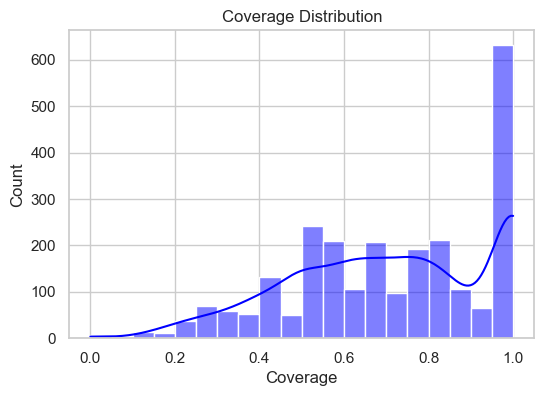

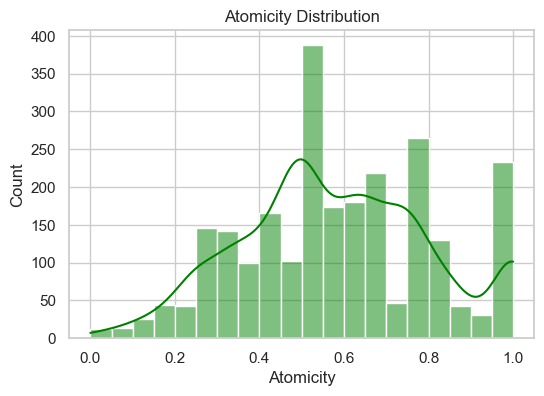

In [11]:
# In[2]: (Code) Histograms for Coverage and Atomicity

plt.figure(figsize=(6, 4))
sns.histplot(results_df["coverage"], kde=True, bins=20, color="blue")
plt.title("Coverage Distribution")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(results_df["atomicity"], kde=True, bins=20, color="green")
plt.title("Atomicity Distribution")
plt.xlabel("Atomicity")
plt.ylabel("Count")
plt.show()


In [14]:
# In[7]: (Code) Flatten Alignment Data for Analysis

def flatten_alignment_map(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row in df, flatten out the 'alignment_map_expanded' 
    so each system claim is its own row.
    
    Returns a DataFrame with columns:
      - dataset
      - source_file
      - example_idx (the original row index)
      - system_claim_idx
      - system_claim_text
      - num_matched_refs
    """
    records = []
    for idx, row in df.iterrows():
        alignment_list = row["alignment_map_expanded"]
        dataset = row["dataset"]
        source_file = row["source_file"]
        
        for sys_claim_obj in alignment_list:
            system_claim_idx = sys_claim_obj["system_claim_idx"]
            system_claim_text = sys_claim_obj["system_claim_text"]
            matched_refs = sys_claim_obj.get("matched_refs", [])
            num_matched = len(matched_refs)
            
            records.append({
                "dataset": dataset,
                "source_file": source_file,
                "example_idx": idx,
                "system_claim_idx": system_claim_idx,
                "system_claim_text": system_claim_text,
                "num_matched_refs": num_matched
            })
    
    return pd.DataFrame(records)

flattened_df = flatten_alignment_map(results_df)
flattened_df.head()


,dataset,source_file,example_idx,system_claim_idx,system_claim_text,num_matched_refs
0,cnndm_test,combined.json,0,0,Juan Arango escaped punishment from the refere...,3
1,cnndm_test,combined.json,0,1,He could face a retrospective punishment for t...,0
2,cnndm_test,combined.json,0,2,Arango had earlier scored a free kick in his t...,5
3,cnndm_test,combined.json,1,0,Gary Gardner confirms he'll report to Aston Vi...,2
4,cnndm_test,combined.json,1,1,The 22-year-old is out on loan at Championship...,0


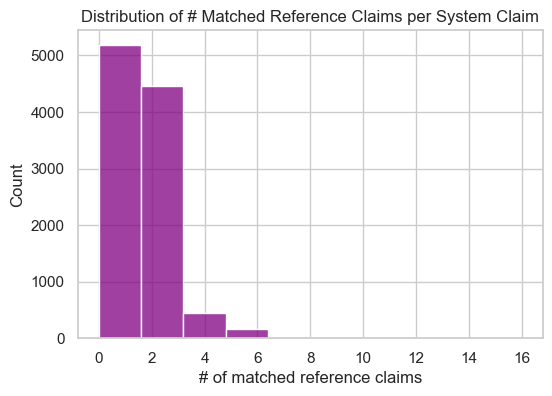

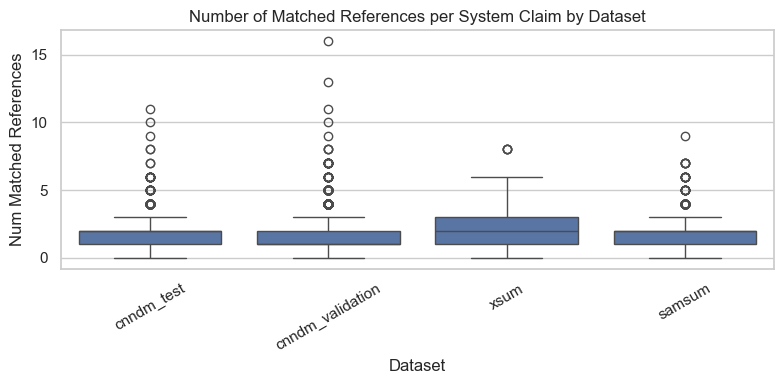

In [15]:
# In[9]: (Code)

plt.figure(figsize=(6,4))
sns.histplot(flattened_df["num_matched_refs"], bins=10, color="purple")
plt.title("Distribution of # Matched Reference Claims per System Claim")
plt.xlabel("# of matched reference claims")
plt.ylabel("Count")
plt.show()

# Optional: we can break it down by dataset:
plt.figure(figsize=(8,4))
sns.boxplot(data=flattened_df, x="dataset", y="num_matched_refs")
plt.title("Number of Matched References per System Claim by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Num Matched References")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Overall matched references:   10535.57
Overall unmatched references: 3832.43


,matched_refs_count,unmatched_refs_count
dataset,,
cnndm_test,2453.290813,1068.709187
cnndm_validation,5171.673574,2213.326426
samsum,1694.461328,205.538672
xsum,1216.141450,344.858550


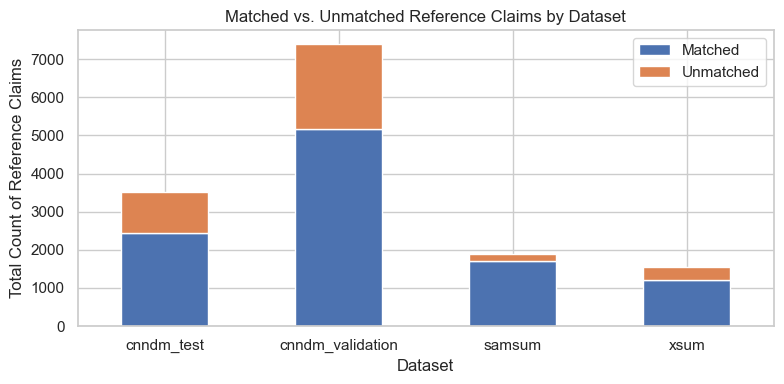

In [16]:
# In[12]: (Code)

# Ensure we have num_reference_claims in our results_df (from earlier steps).
# If not, we can adapt the approach or parse them from alignment_map_expanded.

if "num_reference_claims" not in results_df.columns:
    print("num_reference_claims column not found; ensure it's computed. (Skipping this part.)")
else:
    # Compute matched/unmatched for each row
    results_df["matched_refs_count"] = results_df["coverage"] * results_df["num_reference_claims"]
    results_df["unmatched_refs_count"] = results_df["num_reference_claims"] - results_df["matched_refs_count"]
    
    # Sum across the entire dataset
    total_matched = results_df["matched_refs_count"].sum()
    total_unmatched = results_df["unmatched_refs_count"].sum()
    
    print(f"Overall matched references:   {total_matched:.2f}")
    print(f"Overall unmatched references: {total_unmatched:.2f}")
    
    # Summarize by dataset
    ref_match_summary = results_df.groupby("dataset")[["matched_refs_count", "unmatched_refs_count"]].sum()
    display(ref_match_summary)
    
    # Plot matched vs unmatched in a stacked bar chart or side-by-side
    ref_match_summary.plot(
        kind="bar",
        stacked=True,
        figsize=(8,4),
        title="Matched vs. Unmatched Reference Claims by Dataset"
    )
    plt.xlabel("Dataset")
    plt.ylabel("Total Count of Reference Claims")
    plt.xticks(rotation=0)
    plt.legend(["Matched", "Unmatched"], loc="upper right")
    plt.tight_layout()
    plt.show()


In [17]:
# In[15]: (Code)

def show_alignment_example(row):
    """
    Nicely prints the reference summary, coverage, atomicity, and a preview of alignment_map_expanded.
    """
    print("="*80)
    print(f"Dataset: {row['dataset']} | Source File: {row['source_file']}")
    print(f"Coverage: {row['coverage']:.2f} | Atomicity: {row['atomicity']:.2f}")
    print("Reference Summary:\n", row["reference_summary"], "\n")
    print("Alignment Map Expanded:")
    alignment_map = row["alignment_map_expanded"]
    for sys_claim in alignment_map:
        sys_text = sys_claim["system_claim_text"]
        matched = sys_claim["matched_refs"]
        print(f"  - System Claim [{sys_claim['system_claim_idx']}]: {sys_text}")
        if matched:
            for mref in matched:
                print(f"      -> Matched Ref {mref['ref_idx']}: {mref['ref_claim']}")
        else:
            print("      -> No matched reference claims.")
    print("="*80, "\n")

# Let's pick some examples heuristically:
# High coverage but low atomicity
high_coverage_low_atomicity = results_df[
    (results_df["coverage"] >= 0.8) & (results_df["atomicity"] < 0.2)
].head(1)

# Low coverage but high atomicity
low_coverage_high_atomicity = results_df[
    (results_df["coverage"] < 0.4) & (results_df["atomicity"] >= 0.8)
].head(1)

print("High Coverage, Low Atomicity Example:\n")
if not high_coverage_low_atomicity.empty:
    show_alignment_example(high_coverage_low_atomicity.iloc[0])
else:
    print("No example found with coverage >= 0.8 and atomicity < 0.2")

print("\nLow Coverage, High Atomicity Example:\n")
if not low_coverage_high_atomicity.empty:
    show_alignment_example(low_coverage_high_atomicity.iloc[0])
else:
    print("No example found with coverage < 0.4 and atomicity >= 0.8")


High Coverage, Low Atomicity Example:

Dataset: cnndm_test | Source File: combined.json
Coverage: 0.80 | Atomicity: 0.18
Reference Summary:
 Juan Arango escaped punishment from the referee for biting Jesus Zavela .
He could face a retrospective punishment for the incident .
Arango had earlier scored a free kick in his team's 4-3 defeat . 

Alignment Map Expanded:
  - System Claim [0]: Juan Arango escaped punishment from the referee for biting Jesus Zavela
      -> Matched Ref 0: Juan Arango escaped punishment.
      -> Matched Ref 1: Juan Arango bit Jesus Zavela.
      -> Matched Ref 2: Juan Arango escaped punishment from the referee
  - System Claim [1]: He could face a retrospective punishment for the incident
      -> No matched reference claims.
  - System Claim [2]: Arango had earlier scored a free kick in his team's 4-3 defeat.
      -> Matched Ref 5: Arango had eariler scored a free kick.
      -> Matched Ref 6: Arango scored for his team.
      -> Matched Ref 7: Arango had a de

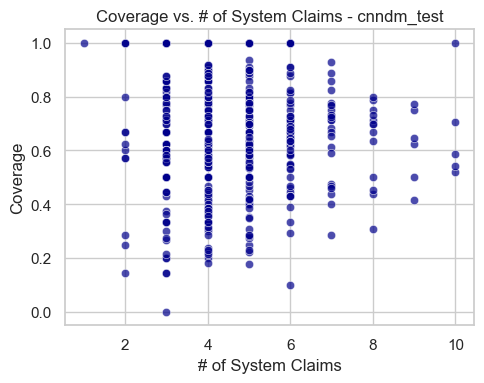

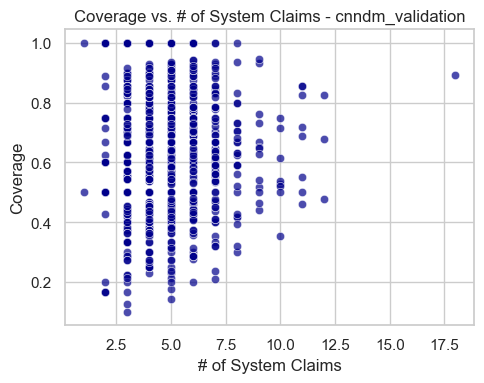

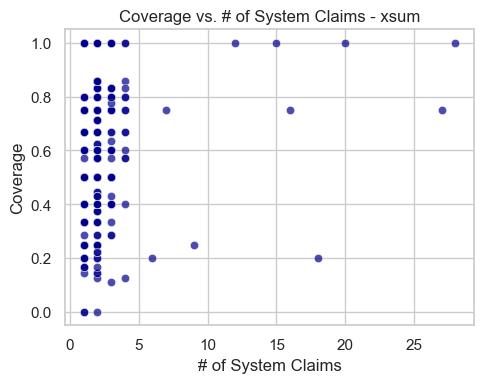

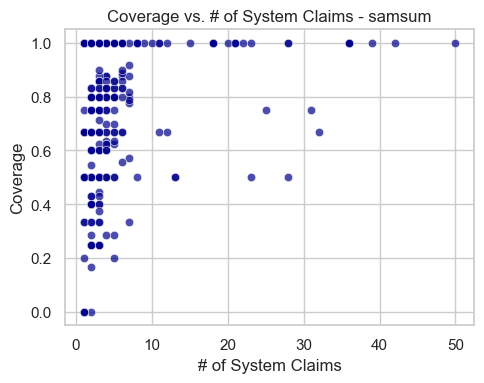

In [20]:
# In[2]: (Code)

datasets = results_df["dataset"].unique()

for ds in datasets:
    ds_df = results_df[results_df["dataset"] == ds]
    plt.figure(figsize=(5, 4))
    sns.scatterplot(
        data=ds_df,
        x="num_system_claims",
        y="coverage",
        alpha=0.7,
        color="darkblue"
    )
    plt.title(f"Coverage vs. # of System Claims - {ds}")
    plt.xlabel("# of System Claims")
    plt.ylabel("Coverage")
    plt.tight_layout()
    plt.show()


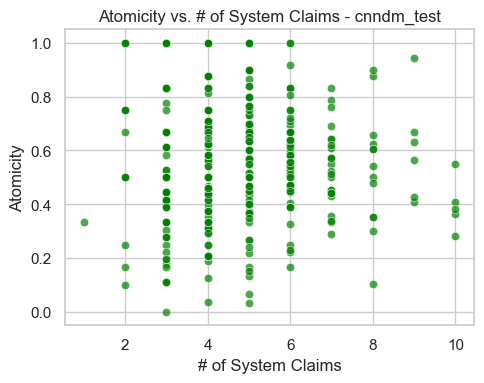

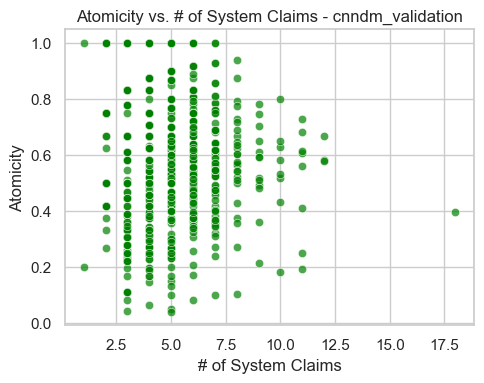

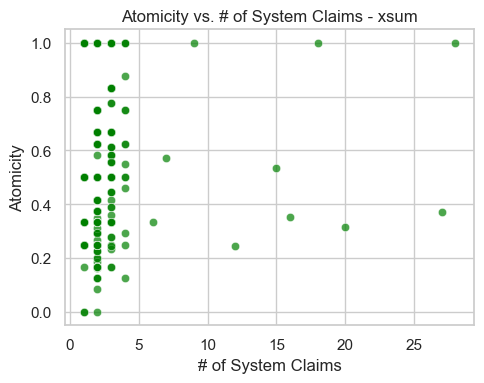

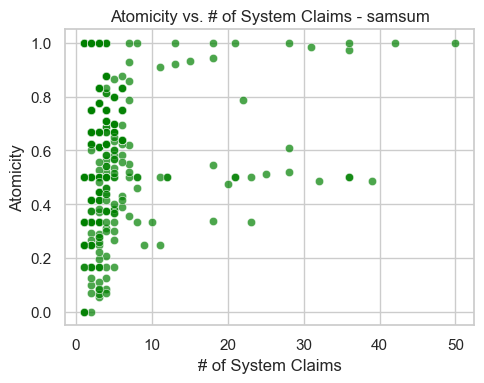

In [21]:
# In[4]: (Code)

for ds in datasets:
    ds_df = results_df[results_df["dataset"] == ds]
    plt.figure(figsize=(5, 4))
    sns.scatterplot(
        data=ds_df,
        x="num_system_claims",
        y="atomicity",
        alpha=0.7,
        color="green"
    )
    plt.title(f"Atomicity vs. # of System Claims - {ds}")
    plt.xlabel("# of System Claims")
    plt.ylabel("Atomicity")
    plt.tight_layout()
    plt.show()


In [23]:
# In[6]: (Code)

def get_top_bottom_examples(df, col, top_n=3, bottom_n=3):
    """
    Returns two DataFrames:
      - top_n examples sorted by descending 'col'
      - bottom_n examples sorted by ascending 'col'
    """
    top_df = df.nlargest(top_n, col)
    bottom_df = df.nsmallest(bottom_n, col)
    return top_df, bottom_df

def display_example_rows(df):
    """
    Prints coverage, atomicity, number of claims, and reference summary for each row in df.
    """
    for i, row in df.iterrows():
        print("="*80)
        print(f"Index: {i}, Dataset: {row['dataset']}, Source: {row['source_file']}")
        print(f"Coverage: {row['coverage']:.2f}, Atomicity: {row['atomicity']:.2f}")
        print(f"Num System Claims: {row.get('num_system_claims', 'N/A')}")
        print("Reference Summary:", row['reference_summary'][:150], "...")
        print("="*80, "\n")


In [24]:
# In[8]: (Code)

results_df["cov_plus_atom"] = results_df["coverage"] + results_df["atomicity"]
top3_cov_atom = results_df.nlargest(3, "cov_plus_atom")

print("=== Top 3 Summaries by (Coverage + Atomicity) ===")
display_example_rows(top3_cov_atom)


=== Top 3 Summaries by (Coverage + Atomicity) ===
Index: 584, Dataset: cnndm_validation, Source: combined.json
Coverage: 1.00, Atomicity: 1.00
Num System Claims: 3
Reference Summary: A Cate Blanchett interview goes awry .
The interviewer tries to ask Blanchett casual questions .
But "Cinderella" star seemingly doesn't take well to  ...

Index: 590, Dataset: cnndm_validation, Source: combined.json
Coverage: 1.00, Atomicity: 1.00
Num System Claims: 2
Reference Summary: Scientists: An epic migration by Jupiter led to destruction of "super-Earths"
The planet-shattering journey laid foundations for Earth, they say . ...

Index: 657, Dataset: cnndm_validation, Source: combined.json
Coverage: 1.00, Atomicity: 1.00
Num System Claims: 3
Reference Summary: Two men accused of committing crimes of "terrorism" and bringing in forged currency .
South Korea's National Intelligence Service denies claim . ...



In [25]:
# In[10]: (Code)

bottom3_cov_atom = results_df.nsmallest(3, "cov_plus_atom")

print("=== Bottom 3 Summaries by (Coverage + Atomicity) ===")
display_example_rows(bottom3_cov_atom)


=== Bottom 3 Summaries by (Coverage + Atomicity) ===
Index: 401, Dataset: cnndm_test, Source: combined.json
Coverage: 0.00, Atomicity: 0.00
Num System Claims: 3
Reference Summary: Border collies Ace and Holly were caught on camera performing a gravity-defying feat together .
The two pooches stood up on their hind legs while bala ...

Index: 1602, Dataset: xsum, Source: combined.json
Coverage: 0.00, Atomicity: 0.00
Num System Claims: 2
Reference Summary: The family of a British man stuck in India, despite being cleared of weapons charges, has expressed disappointment over a delay in his return home. ...

Index: 1643, Dataset: xsum, Source: combined.json
Coverage: 0.00, Atomicity: 0.00
Num System Claims: 1
Reference Summary: Standing on the Washington Mall at the turn of the new millennium, it was impossible not to be struck by America's power and global pre-eminence. ...



In [26]:
# In[12]: (Code)

# Highest coverage but lowest atomicity
# We'll pick top 3 coverage, then sort them by ascending atomicity
high_cov_df = results_df.nlargest(10, "coverage").sort_values("atomicity", ascending=True)
high_cov_low_atom = high_cov_df.head(3)

print("=== High Coverage, Low Atomicity Examples ===")
display_example_rows(high_cov_low_atom)

# Lowest coverage but highest atomicity
low_cov_df = results_df.nsmallest(10, "coverage").sort_values("atomicity", ascending=False)
low_cov_high_atom = low_cov_df.head(3)

print("=== Low Coverage, High Atomicity Examples ===")
display_example_rows(low_cov_high_atom)


=== High Coverage, Low Atomicity Examples ===
Index: 12, Dataset: cnndm_test, Source: combined.json
Coverage: 1.00, Atomicity: 0.42
Num System Claims: 4
Reference Summary: Roger Federer believes Rafael Nadal is still the favourite for Roland Garros .
World No 1 Novak Djokovic has lost just two matches this year .
But Fed ...

Index: 34, Dataset: cnndm_test, Source: combined.json
Coverage: 1.00, Atomicity: 0.44
Num System Claims: 3
Reference Summary: Video shows the lions scaling the cage to look at the people inside .
Lions jump up on the side of the bars and eats meat through them .
The encounter ...

Index: 47, Dataset: cnndm_test, Source: combined.json
Coverage: 1.00, Atomicity: 0.44
Num System Claims: 3
Reference Summary: Alexis Tsipras, Greece’s prime minister, will meet Vladimir Putin in Moscow .
The meeting comes amid reports Russia is considering bailing out Greece  ...

=== Low Coverage, High Atomicity Examples ===
Index: 598, Dataset: cnndm_validation, Source: combined.json
C